In [151]:
%load_ext autoreload
%autoreload 2

from helpers import NormalizedEnv
from helpers import RandomAgent
import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from copy import deepcopy
from tqdm import tqdm
import importlib
from helpers import NormalizedEnv

from heuristicpolicy import HeuristicPendulumAgent
from qnetwork import QNetwork
from policynetwork import PolicyNetwork
from gaussian_action_noise import GaussianActionNoise
from ddpg_agent import DDPGAgent
from replaybuffer import ReplayBuffer
from subplot_curves import subplot
from HeatMap import HeatMap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


In [170]:
MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99
NOISE_STD = 0.3

In [171]:
torch.manual_seed(-1)

#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

noise = GaussianActionNoise(NOISE_STD)

critic  = QNetwork().to(device) # critic
actor = PolicyNetwork().to(device) # policy_network

memory = ReplayBuffer(max_size=BUFFER_SIZE)
agent = DDPGAgent(actor, noise)

In [172]:

q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)
policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)

MSE = nn.MSELoss()

In [173]:
def test_policy(state_batch, actor, critic):

    # function for testing
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    with torch.no_grad():
        policy_loss = -critic(policy_input_state)
        policy_loss = policy_loss.mean()
    
    return policy_loss

In [174]:
def learning_policy(state_batch, policy_optimizer, actor, critic):

    #compute loss for actor
    policy_optimizer.zero_grad()
    # N.B.: do not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # you have to compute them with the current actor - DDPG is an off-policy algorithm
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    policy_loss = -critic(policy_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

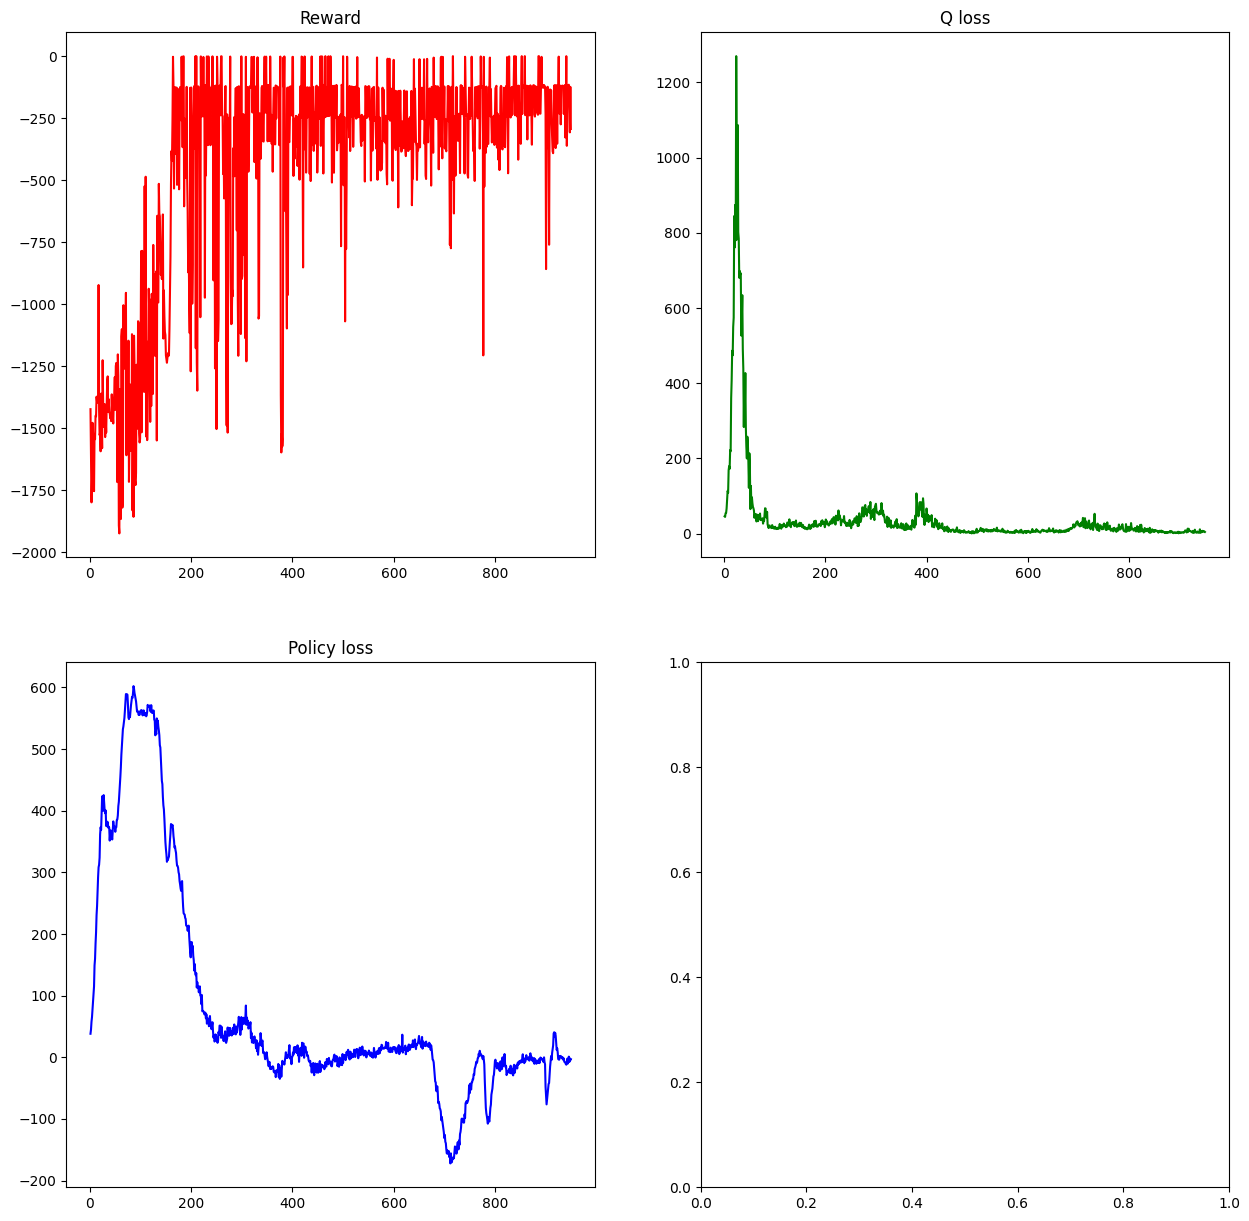

 96%|█████████▌| 955/1000 [29:52<01:24,  1.88s/it]


KeyboardInterrupt: 

In [191]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


average_reward = 0
global_step = 0
nr_of_samples = 128

PRINT_EVERY = 50

for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        action = agent.compute_action(state = current_state, device=device, deterministic=False)
        action = action[0]

        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) #.unsqueeze(1)
            trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)

            # 1-step TD-learning rule                                 
            with torch.no_grad():
                action_next_state = agent.compute_action(state = next_state_batch, device=device) # no grad
                network_input_next_state = torch.cat((next_state_batch, torch.Tensor(action_next_state)),1)
                q_next = critic(network_input_next_state) # should not be differentiated 

            if iter == MAX_IT:
                q_next = 0
            target_state = reward_batch + GAMMA * q_next # the last update in each episode should use q = 0 
            
            network_input_state = torch.cat((state_batch, action_batch),1)
            q = critic(network_input_state)
    
            q_optimizer.zero_grad()
            q_loss = MSE(target_state, q)
            q_loss.backward()
            q_optimizer.step()

            policy_loss = learning_policy(state_batch, policy_optimizer, actor, critic)
            
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])

    except:
        continue
    average_reward += ep_reward

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q)


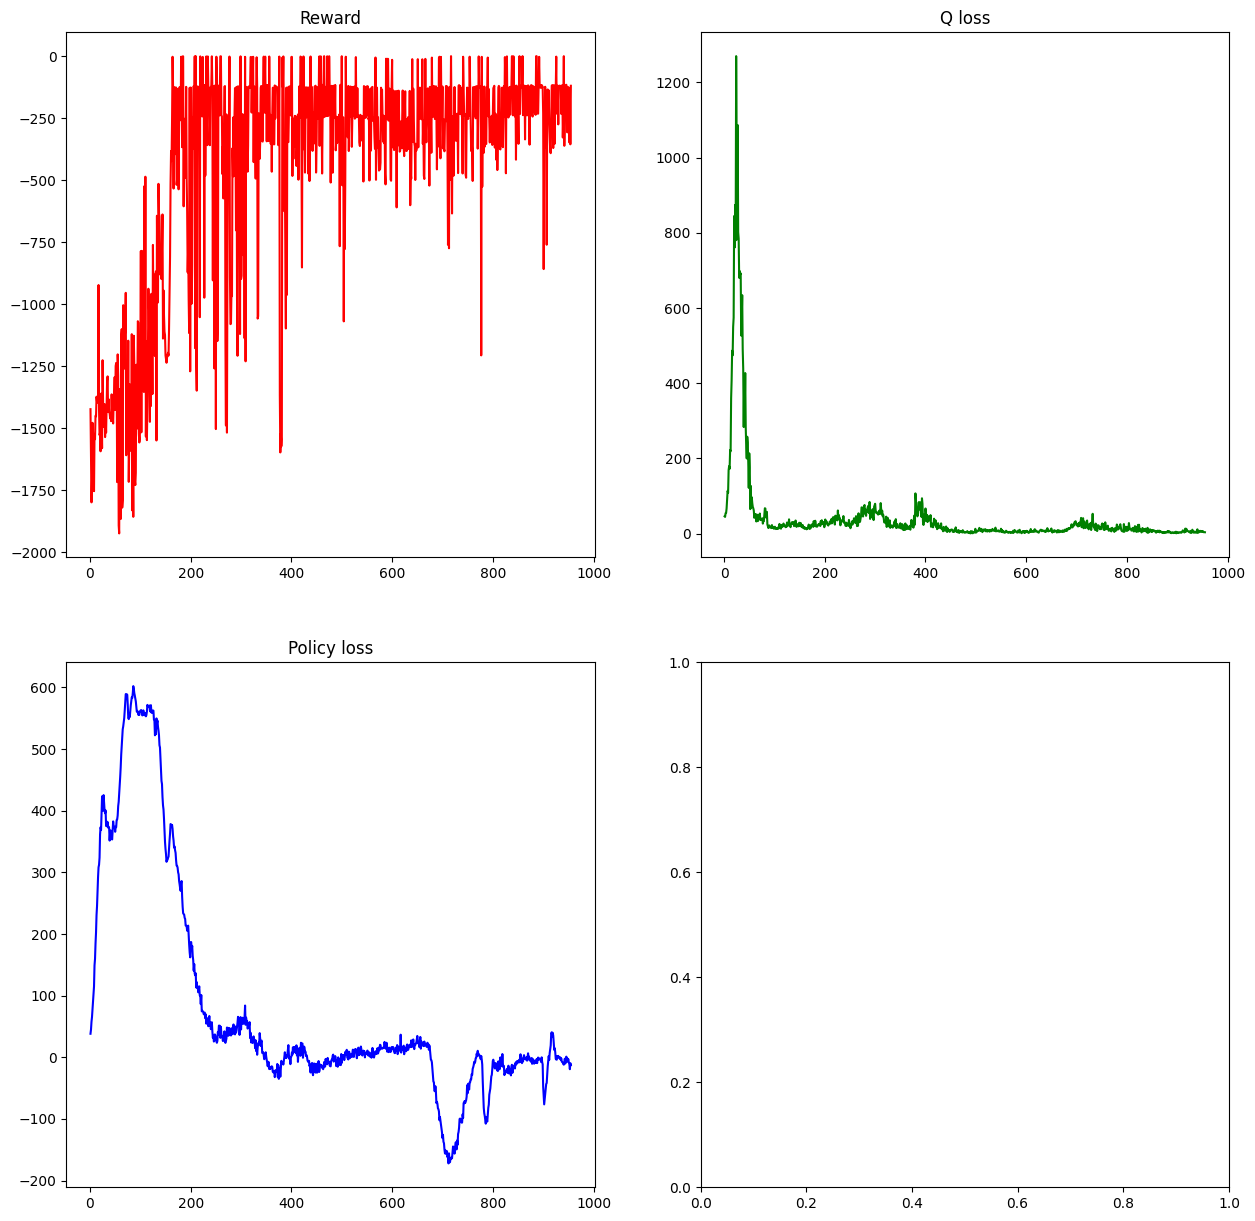

In [193]:
subplot(plot_reward, plot_policy, plot_q)

In [ ]:
HeatMap(critic,Velocity = 0, Action = 0)